Device: cpu


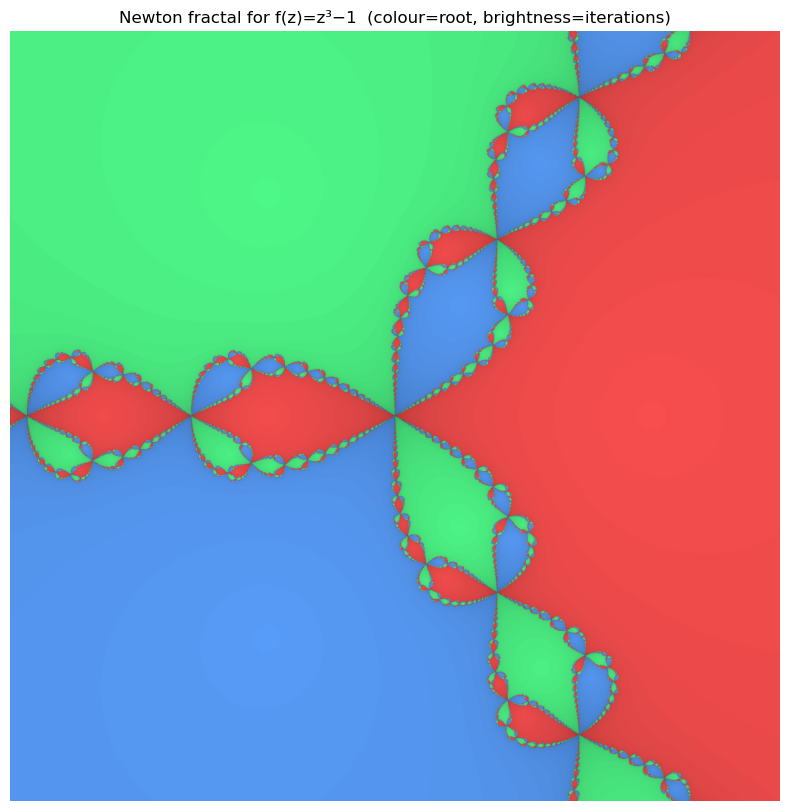

In [2]:
# Newton fractal for f(z) = z^3 - 1 (PyTorch, CPU/GPU)
import torch, numpy as np
import matplotlib.pyplot as plt

# ---------------- Config ----------------
extent = (-1.5, 1.5, -1.5, 1.5)   # (xmin, xmax, ymin, ymax)
step   = 0.0018                   # smaller = higher detail, slower
max_iter = 60
tol = 1e-5

# ------------- Setup device -------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# ------------- Make grid ----------------
xmin, xmax, ymin, ymax = extent
Y, X = np.mgrid[ymin:ymax:step, xmin:xmax:step]      # shape (H, W)
x = torch.tensor(X, dtype=torch.float32, device=device)
y = torch.tensor(Y, dtype=torch.float32, device=device)
z0 = torch.complex(x, y)                              # initial z0 = grid point

# --------- Newton iteration -------------
# f(z) = z^3 - 1,  f'(z) = 3 z^2
roots = torch.tensor([
    1+0j,
    -0.5 + 0.8660254037844386j,
    -0.5 - 0.8660254037844386j
], dtype=torch.complex64, device=device)

iters    = torch.zeros(z0.shape, dtype=torch.int32, device=device)   # iteration count to converge
root_idx = torch.full(z0.shape, -1, dtype=torch.long,  device=device) # which root (0/1/2), -1 if none

with torch.no_grad():
    z = z0.clone()
    for i in range(1, max_iter + 1):
        f  = z*z*z - 1
        fp = 3*z*z
        # avoid division by zero
        fp_safe = torch.where(fp == 0, torch.full_like(fp, 1+0j), fp)
        z = z - f / fp_safe

        # check convergence to nearest root
        dists = torch.stack([torch.abs(z - r) for r in roots], dim=0)   # [3, H, W]
        min_d = dists.min(dim=0)
        close = (min_d.values < tol) & (root_idx == -1)                 # newly converged
        if close.any():
            nearest = dists.argmin(dim=0)                               # Long dtype
            root_idx[close] = nearest[close]                            # dtypes now match
            iters[close]    = i

# --------- Colouring & display ----------
arr_root = root_idx.detach().cpu().numpy()
arr_iter = iters.detach().cpu().numpy().astype(float)
arr_iter[arr_iter == 0] = max_iter

H, W = arr_root.shape
img = np.zeros((H, W, 3), dtype=np.uint8)

# palette per root (RGB)
palette = np.array([
    [255,  80,  80],   # root 0: reddish
    [ 80, 255, 140],   # root 1: greenish
    [ 90, 160, 255],   # root 2: bluish
], dtype=np.float32)

for k in (0, 1, 2):
    mask = (arr_root == k)
    if mask.any():
        base = palette[k]
        # brightness: faster convergence -> brighter
        brightness = 0.3 + 0.7*(1.0 - (arr_iter[mask] / arr_iter.max()))
        img[mask] = (base * brightness[:, None]).clip(0, 255).astype(np.uint8)

# non-converged → black
img[arr_root == -1] = 0

plt.figure(figsize=(10, 10))
plt.imshow(img, extent=(xmin, xmax, ymin, ymax), origin='lower')
plt.axis('off')
plt.title("Newton fractal for f(z)=z³−1  (colour=root, brightness=iterations)")
plt.show()
